## Table of Contents  <a class="anchor" id="toc"></a>  

[Data Cleaning](#cleaning)  
[EDA](#eda)  
[Making Dummies](#dummies)  
[Basic Modeling](#basic_modeling)   
[KNN Model](#knn_model)  
[Logistic Regression Model](#lr_model)  
[XGBoost Model](#xgb_model)  
[Random Forest Model](#rf_model)  
[ROC Curves for Base Models](#roc_base)  
[CatBoost Model](#cb_model)  
[XGB Tuning](#xgb_tuning)  
[Feature Importance](#feature_importance)  
[Interpretation](#interpretation)  
[End](#end)

[link](https://www.kaggle.com/sonalidasgupta95/churn-prediction-of-bank-customers)

The dataset contains 10,000 observations, each representing a particular customer of the bank (current or former).

**COLUMNS:**

**CustomerId:** Unique numeric identifier of customer  
**Surname:** Surname of customer  
**CreditScore:** Credit score of customer  
**Geography:** Customer's country of residency  
**Gender:** Male or Female  
**Age:** Age of the customer  
**Tenure:** Number of years the customer has been with the bank  
**Balance:** Bank balance of the customer  
**NumOfProducts:** Number of bank products the customer is utilising  
**HasCrCard:** Binary Flag for whether the customer holds a credit card with the bank or not  
**IsActiveMember:** Binary Flag for whether the customer is an active member with the bank or not  
**EstimatedSalary:** Estimated salary of the customer in Dollars  
**Exited:** Binary flag 1 if the customer closed account with bank and 0 if the customer is retained  




In [277]:
import pandas as pd
import numpy as np
import pandas_profiling
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

from ipywidgets import interact
from collections import Counter, defaultdict
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from imblearn.over_sampling import ADASYN

%config InlineBackend.figure_format = 'svg'

# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Data Cleaning <a class="anchor" id="cleaning"></a>  
[TOC](#toc)

In [2]:
data = pd.read_csv('/Users/mcr/Metis/Data Sets/Churn_Modelling.csv')
data


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


We see that there are a number of columns that are irrelevant to the purposes of our analysis, namely, the `RowNumber`, `CustomerId`, and `Surname` columns. Let's remove them.

In [3]:
# Remove unnecessary columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


It appears that there are no NaN values. Now let's move on to EDA.

## Exploratory Data Analysis  <a class="anchor" id="eda"></a>  
[TOC](#toc)

In [5]:
pd.read_csv('/Users/mcr/Metis/Data Sets/Churn_Modelling.csv').profile_report()

## Takeaways

This is a lot of info, but here are some noteworthy takeaways.  
  
**Value Types:** 
1. There are 5 features that are continuous numericals
2. There are 3 categorical features (# prods, geography, gender), however, gender can be reclassified as Boolean, since it only has two possible values
3. There are 2 Boolean features
4. Our target (whether or not the customer exited the bank) is also Boolean

**Distributions:**
1. AGE: normally distributed around a mean of ~39 and their distribution skews right. At first, this looks like a representative sample of the adult population.
2. BALANCE: normally distributed around a mean of ~76,500, however, 36% of the values are zero. **This may be problematic. Let's change this feature into a Boolean, where 1 represents the customer has a balance and 0 indicates their balance is 0.*** Also, apart from the zeros, there are only 3 values below 15,000, which suggests that perhaps we are only looking at a wealthier segment of the population.  
3. CREDIT SCORE: normally distributed around 650 (median=652), which is the border between "bad" and "fair." However, the mode is 850 (4x the next most common value). 850 is a perfect credit score. This fact again suggests that we're dealing with a more desireable customer base from a business perspective. 
4. ESTIMATED SALARY: evenly distributed (0 < value < 200,000). 
5. GENDER: there are more males represented in the data than females, but the imbalance isn't egregious. 
6. GEOGRAPHY: about half of the customers are from France, while the rest are evenly split between Germany and Spain.
7. CREDIT CARD: most respondents have a credit card with the bank (70%).
8. IS ACTIVE MEMBER: just over half of the respondents are active members. Since we don't have a formal definition of this, it's difficult to glean much in-depth insight from this feature, but it sounds valuable to what we're predicting, so it's probably worth keeping.
9. NUMBER OF PRODUCTS: most have one, and nearly all have 2. ~3% have more than 2.
10. TENURE WITH BANK: very close to evenly distributed over a 10-year period
11. EXITED BANK (TARGET): 20% have exited, while 80% remain customers of the bank. This number suggests that those who have exited were oversampled, since we don't expect the bank to have lost 20% of its customers, though this isn't impossible.



\* After trying this, it did not yield better results than leaving it as is, therefore, the data in this notebook does NOT reflect a conversion of the balance feature to Boolean.

**Correlations:** There seems to be a negative correlation between balance and number of products, as well as between active customer and exited the bank (which is intuitive). Also, there is some positive correlation with two of our features (age & balance) and whether the customer exited the bank. This will be interesting to explore more later. 

In [7]:
num_exited = len(data[data['Exited'] == 1])
num_stayed = len(data[data['Exited'] == 0])

print('Num exited customers: {}'.format(num_exited))

print('Num retained customers: {}'.format(num_stayed))

print('Expected accuracy if predicting majority class every time: {}'.format(num_stayed / len(data))
     )
    

Num exited customers: 2037
Num retained customers: 7963
Expected accuracy if predicting majority class every time: 0.7963


## Making Dummies  <a class="anchor" id="dummies"></a>  
[TOC](#toc)

Since a number of our columns are categorical, we'll need to convert these to dummies. 

In [8]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:

data2 = pd.get_dummies(data, drop_first=True)
data2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


This call successfully dummied the Gender and Geography features, but not the NumOfProducts feature. Let's do that manually.

In [10]:
num_map = {'NumOfProducts': 
           {1:'one', 2:'two', 3:'three', 4:'four'}
          }
data2.replace(num_map, inplace=True)
data2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,one,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,one,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,three,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,two,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,one,1,1,79084.10,0,0,1,0


In [11]:
# Re-call get_dummies 
data2 = pd.get_dummies(data2, drop_first=True)
data2.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_one,NumOfProducts_three,NumOfProducts_two
0,619,42,2,0.00,1,1,101348.88,1,0,0,0,1,0,0
1,608,41,1,83807.86,0,1,112542.58,0,0,1,0,1,0,0
2,502,42,8,159660.80,1,0,113931.57,1,0,0,0,0,1,0
3,699,39,1,0.00,0,0,93826.63,0,0,0,0,0,0,1
4,850,43,2,125510.82,1,1,79084.10,0,0,1,0,1,0,0


Great. Everything worked. Now, for the sake of making things easy, let's move the target column to index 0.

In [12]:
first = data['Exited']
data2.drop(labels=['Exited'], axis=1,inplace = True)
data2.insert(0, 'Exited', first)
data2.head()

,Exited,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_one,NumOfProducts_three,NumOfProducts_two
0,1,619,42,2,0.00,1,1,101348.88,0,0,0,1,0,0
1,0,608,41,1,83807.86,0,1,112542.58,0,1,0,1,0,0
2,1,502,42,8,159660.80,1,0,113931.57,0,0,0,0,1,0
3,0,699,39,1,0.00,0,0,93826.63,0,0,0,0,0,1
4,0,850,43,2,125510.82,1,1,79084.10,0,1,0,1,0,0


In [13]:
import pickle

with open('data2.pickle', 'wb') as to_write:
    pickle.dump(data2, to_write)

In [14]:
# Convert "Balance" column to Boolean
# data2['Balance'] = np.where(data2['Balance'] > 0, 1,0)
# data2['Balance'] = data2['Balance'].astype(bool)
# data2

## **BASIC MODELING** <a class="anchor" id="basic_modeling"></a>  
[TOC](#toc)

Let's begin with a simple KNN model just to see what kind of results we an achieve.

## KNN <a class="anchor" id="knn_model"></a>  


In [233]:
# Separate data into train/test parcels
X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:, 1:], data2['Exited'],
                                                            test_size=0.2, random_state=41, 
                                                            stratify=data2['Exited'])

# Scale the train data 
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [16]:
# Define a KNN function to get the best K-value

best_knn = KNeighborsClassifier(n_neighbors=1)

def KNN_get_K(X_tr, y_train, X_te, y_test):
    """
    Calculate the K-value that yields the highest accuracy and print the results.
    Arguments: X_train, y_train, X_test, y_test
    Prints: Highest KNN model score for 1 < K < 20
            Optimal K-value
    """
    
    best_k = 0
    high_score = 0
    
    for k in range(1, 20):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tr, y_train)
        score = knn.score(X_te, y_test)
        
        if score > high_score:
            high_score = score
            best_k = k
            global best_knn 
            best_knn = KNeighborsClassifier(n_neighbors=k)
            best_knn.fit(X_tr, y_train)
            y_predict = best_knn.predict(X_te) 
        else:
            continue 
            
    print("The best score for KNN is:")
    print("Training: {:6.2f}%".format(100*best_knn.score(X_tr, y_train)))
    print("Test set: {:6.2f}%".format(100*best_knn.score(X_te, y_test)))
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
    print("Best K-value: {}".format(best_k))



In [17]:
KNN_get_K(X_tr, y_train, X_te, y_test)

The best score for KNN is:
Training:  85.54%
Test set:  84.15%
Precision: 0.6923,   Recall: 0.3980
Best K-value: 11


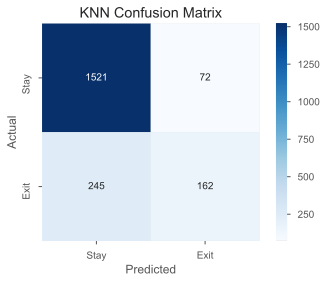

In [18]:
# Print confusion matrix for kNN

from sklearn.metrics import confusion_matrix

knn_confusion = confusion_matrix(y_test, best_knn.predict(X_te))
plt.figure(dpi=150)
ax = sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix');

We see now that the 84.15% accuracy is deceiving. Since we care most about recall, and this model's recall score was only 0.398, it doesn't serve us very well. 

## Logistic Regression  <a class="anchor" id="lr_model"></a>  
[TOC](#toc)

In [170]:
# Define a Logistic Regression function to get best C value

def lr_get_C(X_tr, y_train, X_te, y_test):
    global best_C
    global best_lr
    best_C = 0
    high_score = 0
    for C in np.arange(.01, 1, 50):
        lr = LogisticRegression(solver= 'liblinear', C=C)
        lr.fit(X_tr, y_train)
        lr.score(X_tr, y_train)
        score = lr.score(X_te, y_test)
        if score > high_score:
            high_score = score
            best_C = C
            best_lr = LogisticRegression(solver= 'liblinear', C=C)
            best_lr.fit(X_tr, y_train)
        else:
            continue 
            
    print("The best score for Logistic Regression is")
    print("Training: {:6.2f}%".format(100*best_lr.score(X_tr, y_train)))
    print("Test set: {:6.2f}%".format(100*best_lr.score(X_te, y_test)))
    print("Best C-value: {}".format(best_C))


In [171]:
lr_get_C(X_tr, y_train, X_te, y_test)

The best score for Logistic Regression is
Training:  83.40%
Test set:  84.10%
Best C-value: 0.01


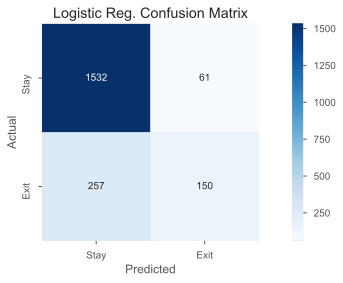

In [173]:
# Print confusion matrix for logistic regression
best_lr.fit(X_tr, y_train)
logit_confusion = confusion_matrix(y_test, best_lr.predict(X_te))
plt.figure(dpi=150)
ax = sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Reg. Confusion Matrix');

In [174]:
# Using the default threshold of 0.5 (default predict threshold)
y_predict = best_lr.predict(X_te)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7109,   Recall: 0.3686


The logistic regression model predicted exiting customers, which is good, but it severely underpredicted them. In our business case, we really want to identify as many of the customers who will exit as possible, so we want to maximize the recall of our model. It's ok if this comes at the expense of the precision. Let's see if we can increase the recall score.

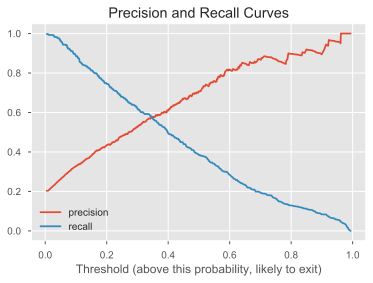

In [23]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_te)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, likely to exit)');
plt.title('Precision and Recall Curves');

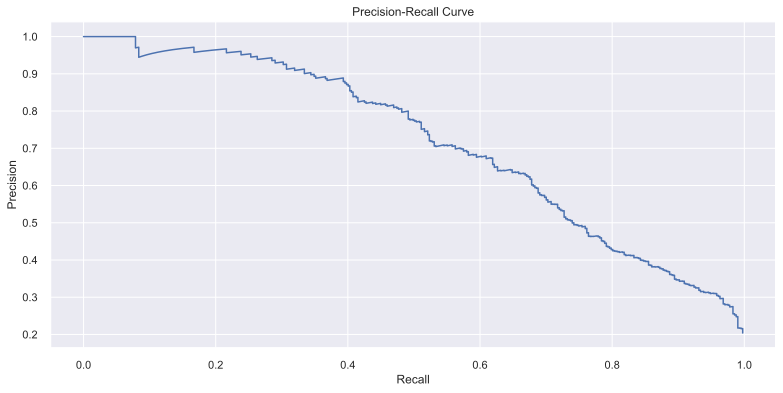

In [271]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [25]:
def find_threshold(X_tr, y_train, X_te, y_test, model, precision_floor):
    
    model.fit(X_tr, y_train)
    best_recall = 0
    best_thresh = 0
    best_precision = 0
    precision_floor = precision_floor
    
    for thresh in np.linspace(.05, .95, 80):
        y_predict = (model.predict_proba(X_te)[:, 1] > thresh)
        recall = recall_score(y_test, y_predict)
        precision = precision_score(y_test, y_predict)
        if recall > best_recall and precision >= precision_floor:
            best_precision = precision
            best_recall = recall
            best_thresh = thresh
        else:
            continue
            
    print("Threshold of {}:".format(best_thresh))
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(best_precision, best_recall))
                                                     

    #print("Threshold of {}:".format(thresh))
    #print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), recall))
                                                     


In [175]:
find_threshold(X_tr, y_train, X_te, y_test, best_lr, .6)

Threshold of 0.4145569620253164:
Precision: 0.6132,   Recall: 0.4791


Let's see how other models perform. We'll also try to correct the class imbalance of our target reflected in the dataset we have.

## Oversampling <a class="anchor" id="oversampling"></a>  
[TOC](#toc)

In [27]:
from imblearn.over_sampling import RandomOverSampler

# Resample our training data to balance the target classes
ros = RandomOverSampler(random_state=41)
X_resample, y_resample = ros.fit_sample(X_tr, y_train)

Counter(y_resample)

Counter({0: 6370, 1: 6370})

## Rerun Logistic Regression with Oversampled Data

In [178]:
lr_get_C(X_resample, y_resample, X_te, y_test)

The best score for Logistic Regression is
Training:  75.64%
Test set:  75.10%
Best C-value: 0.01


In [181]:
# Using the default threshold of 0.5 (default predict threshold)
lr = LogisticRegression()
best_lr.fit(X_resample, y_resample)
y_predict = best_lr.predict(X_te)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.4349,   Recall: 0.7469


## XGBoost <a class="anchor" id="xgb_model"></a>  
[TOC](#toc)

In [30]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions

In [31]:
xgb = XGBClassifier().fit(X_tr, y_train)
xgb_pred = xgb.predict(X_te)
accuracy = accuracy_score(y_test, xgb_pred)
print(f'XGB Accuracy: {round(accuracy, 4)*100}')

XGB Accuracy: 86.85000000000001


This is our best accuracy score, but we know we can't simply use the accuracy as our model's primary metric of value. We really need to find the best mix of precision and recall. Let's examine these.

In [32]:
print("XGB model:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, xgb_pred), 
                                                     recall_score(y_test, xgb_pred)))

XGB model:
Precision: 0.7791,   Recall: 0.4939


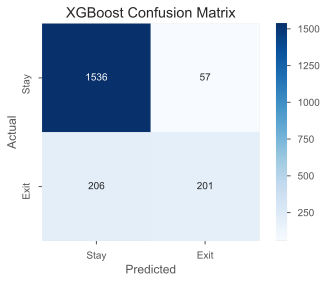

In [33]:
# Print confusion matrix for XGB
xgb_confusion = confusion_matrix(y_test, xgb_pred)
plt.figure(dpi=150)
ax = sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix');

This is a significant improvement, but 49% recall is still not very good. Let's take a look at one more model to get baselines on our model predictions, and then we can explore other avenues of refining our predictions.

## Random Forest <a class="anchor" id="rf_model"></a>  
[TOC](#toc)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_tr, y_train)
rf_pred = rf.predict(X_te)
accuracy = accuracy_score(y_test, rf_pred)

print("Random Forest Model:")
print(f'Accuracy: {round(accuracy, 4)*100}')
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, rf_pred), 
                                                     recall_score(y_test, rf_pred)))

Random Forest Model:
Accuracy: 86.25
Precision: 0.7426,   Recall: 0.4963


## ROC Curves for Base Models <a class="anchor" id="roc_base"></a>  
[TOC](#toc)

Let's plot all of our models' ROC curves to get an idea of how they compare to one another. We'll also throw in a couple of other models for good measure, just to see.

In [372]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(), 
               XGBClassifier(), 
               KNeighborsClassifier(n_neighbors=8), 
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GaussianNB()
              ]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_tr, y_train)
    yproba = model.predict_proba(X_te)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
    result_table = result_table.sort_values('auc', ascending=False)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

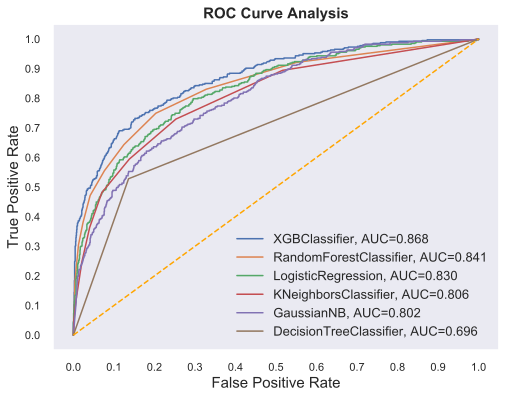

In [373]:
# Plot the figure
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.grid(b=None)
#plt.savefig('ROC2.png', format='png', transparent=True)
plt.show()


## CatBoost <a class="anchor" id="cb_model"></a>  
[TOC](#toc)

In [103]:
categorical_features_indices = np.where(Xc_train.dtypes != np.float)[0]


In [114]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.2, random_state=41, stratify=data['Exited'])

In [115]:
Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc_train, yc_train, test_size=.25, random_state=41, stratify=yc_train)

In [357]:
import catboost 
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1)

cat_model = cat.fit(Xc_train, yc_train, cat_features=categorical_features_indices, eval_set=(Xc_val, yc_val), verbose=False)



In [128]:
cat_pred = cat_model.predict(Xc_test)
cat_proba = cat_model.predict_proba(Xc_test)

In [130]:
@interact(thresh=(0, 1, .01))
def cat_confusion(thresh):
    y_predict = (cat_model.predict_proba(Xc_test)[:, 1] > thresh)
    precision = precision_score(yc_test, y_predict)
    recall = recall_score(yc_test, y_predict)
    f2 = 5 * ((precision*recall) / ((4*precision) + recall))
    xgb_confusion = confusion_matrix(yc_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Catboost Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F2: {:6.4f}".format(precision, recall, f2)

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

## Hyperparameter Tuning - XGBoost <a class="anchor" id="xgb_tuning"></a>  
[TOC](#toc)


In [74]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_validate
import xgboost as xgb
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# #Separate data into train/test parcels
# X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:, 1:], data2['Exited'],
#                                                             test_size=0.2, random_state=41, 
#                                                             stratify=data2['Exited'])

# # # Scale the train data 
# # std = StandardScaler()
# # std.fit(X_train.values)
# # X_tr = std.transform(X_train.values)
# # X_te = std.transform(X_test.values)

X_TRAIN, X_test, y_train, y_test = train_test_split(data2, data2['Exited'],
                                                             test_size=0.2, random_state=41, 
                                                             stratify=data2['Exited'])

# Remove the target column from the X_test data so we can use it in our model later
X_test = X_test.drop('Exited', axis=1)

train = X_TRAIN
target = 'Exited'

Let's define a function which will help us create XGBoost models and perform cross-validation. (source: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/))

In [38]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Exited'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Exited'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Exited'], dtrain_predprob))
                

In [39]:
# Choose all predictors except target 
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train, predictors)


Model Report
Accuracy : 0.8735
AUC Score (Train): 0.896792


In [136]:
# Tune the optimum number of trees using cv function of xgboost
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.05, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27,), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5,
)

gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.8573412564648322)

The above test shows that the ideal max_depth is 3 and the ideal min_child_weight is 1. Let's run one more test to see if we can optimize this further by looking at intervals 1 above and below these parameters, since we searched by intervals of 2 before. 

In [41]:
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, n_estimators=1000, max_depth=5,
    min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 2, 'min_child_weight': 2}, 0.8628434667873757)

It looks like 2 is the optimal setting for these parameters. Let's move on to gamma tuning.

In [42]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=1000, max_depth=2,
    min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective='binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_


({'gamma': 0.0}, 0.8628434667873757)

This test indicates that our original gamma setting of 0 is optimal, so we'll retain this value. Let's stop tuning here for this model. 

In [43]:
# Save the optimized XGB model, fit to our training data
xgb_model = XGBClassifier(learning_rate =0.05, n_estimators=1000, max_depth=2,
    min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective='binary:logistic', nthread=4, scale_pos_weight=1,seed=27).fit(X_tr ,y_train)


In [359]:
xgb_model.feature_names = X_train.columns
xgb_model.target_names = ['Exited', 'Customer']

In [360]:
# Pickle the model

import pickle 

with open('xgb_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_model, to_write)

In [313]:
from yellowbrick.classifier import DiscriminationThreshold

# Instantiate the classification model and visualizer
visualizer = DiscriminationThreshold(xgb_model, fbeta=1.5)

visualizer.fit(X_tr, y_train)
plt.grid(b=None)
plt.savefig('Threshold.png', format='png', transparent=True)
visualizer.show()           

In [298]:
from ipywidgets import interact

# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def xgb_confusion(thresh):
    y_predict = (xgb_model.predict_proba(X_te)[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f2 = (5) * ((precision*recall) / (((4)*precision) + recall))
    xgb_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(xgb_confusion, cmap=plt.cm.GnBu, annot=True, square=True, fmt='g', 
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('XGBoost Confusion Matrix')
    
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F2: {:6.4f}".format(precision, recall, f2)
                                                     



interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

## Feature Importance <a class="anchor" id="feature_importance"></a>  
[TOC](#toc)

In [164]:
lr_feature_importance = list(zip(X_train.columns, lr.coef_[0]))
lr_feature_importance = sorted(lr_feature_importance, key=lambda x: x[1], reverse=True)
lr_feature_importance

[('Age', 0.6089574109511988),
 ('NumOfProducts_three', 0.3650291314911882),
 ('Geography_Germany', 0.33104635142006233),
 ('EstimatedSalary', 0.030143733139486747),
 ('Geography_Spain', -0.011135423349734823),
 ('HasCrCard', -0.011833804864477595),
 ('Balance', -0.019520880667683534),
 ('CreditScore', -0.03480796094063877),
 ('Tenure', -0.03833637628571309),
 ('NumOfProducts_one', -0.04226319589722587),
 ('Gender_Male', -0.21244369362600016),
 ('IsActiveMember', -0.43950199663299805),
 ('NumOfProducts_two', -0.6794028521493369)]

In [166]:
xgb_feature_importance = list(zip(X_train.columns, xgb_model.feature_importances_))
xgb_feature_importance = sorted(xgb_feature_importance, key=lambda x: x[1], reverse=True)
xgb_feature_importance

[('NumOfProducts_two', 0.21935117),
 ('IsActiveMember', 0.150732),
 ('NumOfProducts_three', 0.14030564),
 ('NumOfProducts_one', 0.12447787),
 ('Age', 0.118073195),
 ('Geography_Germany', 0.0694788),
 ('Gender_Male', 0.05416165),
 ('Balance', 0.03561892),
 ('Geography_Spain', 0.020726569),
 ('EstimatedSalary', 0.017694756),
 ('CreditScore', 0.016637435),
 ('HasCrCard', 0.016596299),
 ('Tenure', 0.0161457)]

In [168]:
# data_features = data.columns
# data_features = data_features.drop('Exited')
cat_feature_importance = list(zip(data_features, cat.feature_importances_))
cat_feature_importance = sorted(cat_feature_importance, key=lambda x: x[1], reverse=True)
cat_feature_importance                           

[('NumOfProducts', 37.84846931136878),
 ('Age', 33.95156619391314),
 ('IsActiveMember', 12.72233367441726),
 ('Geography', 8.188261699413292),
 ('Balance', 4.388760302570971),
 ('Gender', 2.8630440065062994),
 ('Tenure', 0.028477842043724),
 ('EstimatedSalary', 0.009086969766524743),
 ('CreditScore', 0.0),
 ('HasCrCard', 0.0)]

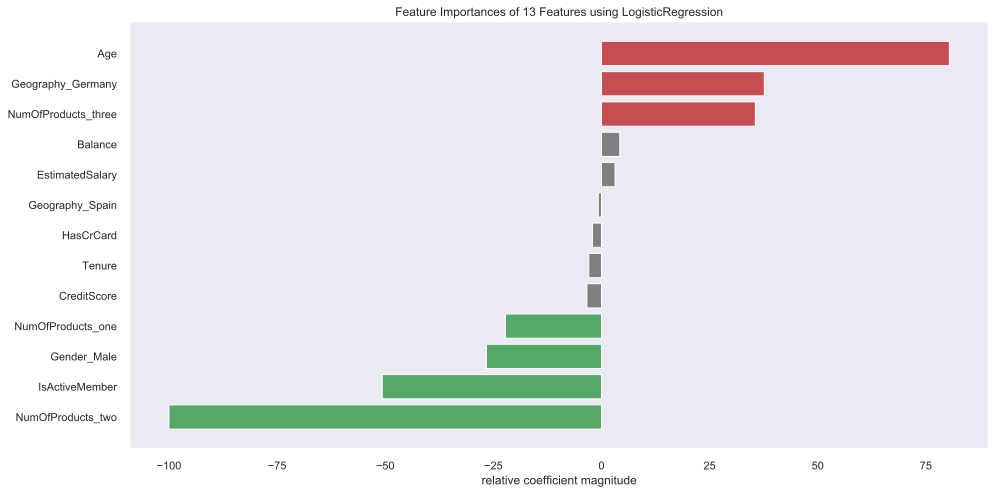

In [326]:
# Display relative feature importances of logistic regression model
colors = ['g','g','g','g','gray','gray','gray','gray','gray','gray','r','r','r']
viz = FeatureImportances(best_lr, labels=X_train.columns, relative=True, colors=colors)
viz.fit(X_tr, y_train)
plt.grid(b=None)
plt.savefig('feature_importance.png', format='png', transparent=True)
viz.show()

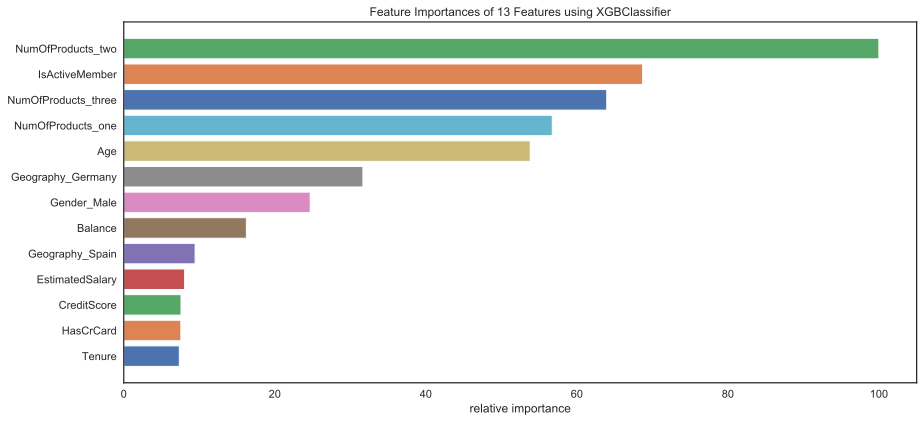

In [279]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(xgb_model, labels=X_train.columns)
viz.fit(X_tr, y_train)
viz.show()

## Interpretation <a class="anchor" id="interpretation"></a>  
[TOC](#toc)

Let's calculate the average balance of the people who have exited the bank.

In [134]:
exited = data2[data2.Exited == 1]
customers = data2[data2.Exited == 0]
num_exited = len(exited)
exited_no_balance = len(exited[exited.Balance == 0])
exited_w_balance = len(exited[exited.Balance != 0])

print("Mean balance of all exited customers: € {:,.2f}".format(exited.Balance.mean()))
print('% of exited customers who took money with them: {:.2f}%'.format((exited_w_balance / num_exited) * 100))

# table = ff.create_table(exited)
# iplot(table)

Mean balance of all exited customers: € 91,108.54
% of exited customers who took money with them: 75.45%


This is a lot of money! Without other data, a frequentist can only assume that the typical exiting customer is worth approximately €91,000 to the bank. How do we incentivize customers to stay? Well, we see that the strongest predictor of whether a person will exit the bank is whether or not they have exactly two products. However, our logistic regression model also indicates that if they have exactly three accounts, they are significantly more likely to leave the bank. This is puzzling, and something to explore in a future study. For the time being, it may be reasonable to consider as strong assets our customers who have two products, and perhaps we should avoid pushing further products on them.  
  
Something else is very interesting. Our models all indicate that customer age is strongly predictive of churn probability. Let's look into this.

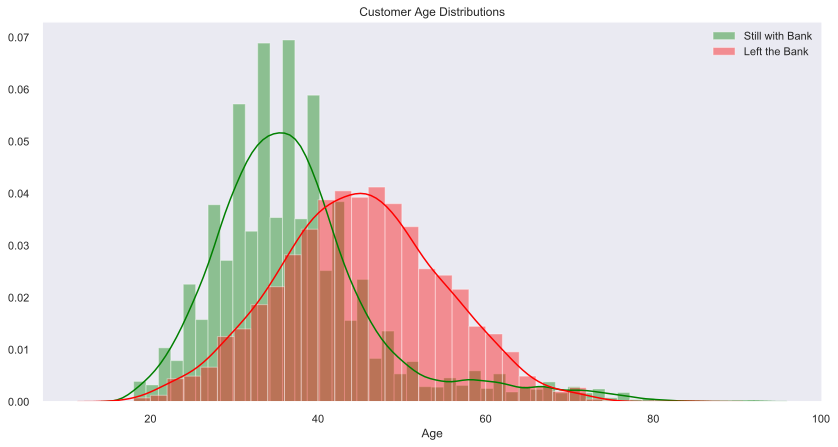

In [335]:
# Plot kde of age of exited customers vs. age of retained customers
sns.set(rc={'figure.figsize':(14, 7)})
ax1 = sns.distplot(customers.Age, color='green', label='Still with Bank').set_title('Customer Age Distributions')
ax2 = sns.distplot(exited.Age, color='red', label='Left the Bank')
plt.grid(b=None)
# plt.savefig('age.png', format='png', transparent=True)
plt.legend()


In [365]:
customers.Age.median(), exited.Age.median()

(36.0, 45.0)

In [288]:
customers.Age.mode(), exited.Age.mode()

(0    35
 dtype: int64, 0    46
 dtype: int64)

We see that there is a marked separation of our target classes when viewed through the lens of age. Our customers who are leaving tend to be, on average, about 10 years older--in their mid-40s. The distribution of our retained customers skews right, while the distribution of exited customers has no such skew. The graph shows that we're most likely to lose customers between 40 and 65 years old. We should focus on incentivizing our current customers who are in this age group, as well as look at what might be causing people to exit as they approach 40.  

The fact that our exiting customers tend to be older is particularly problematic for two reasons:  
1. These customers have had the time to accummulate more money, so losing them is generally more costly than losing a younger customer.
2. These customers are probably less likely to be strongly incentivized by short-term or one-time offers. It's likely that these are more financially sophisticated people who are looking for more long-term incentives like better interest rates on CDs and other financial products.

In [336]:
exited.Balance.mean()

91108.53933726068

In [363]:
exited.Balance.mean() / customers.Balance.mean()

1.2524320247703886

 <a class="anchor" id="end"></a>  
 
 [TOC](#toc)